# Hypothesis Testing Project

# Introduction

## The Project

This project uses the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company.

The goal of this project is to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company.

### The Deliverables

The goal of this project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be important information for the company.

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test.


## Methodology

In this project I will use the Scientific Method. The step are as follows:

### 1. Make an Observation

The first step of the scientific method is to observe something that I want to test. This step involves exploring the data and looking for something that is worth testing. 

### 2. Examine the Research

This means identifying any research that already exists which may help answer my question, directly or indirectly. For the purposes of this project, my research will be limited to investigating the 

### 3. Form a Hypothesis

In this stage, I will formulate two hypotheses to test--your educated guess about the outcome  called the **_Alternative Hypothesis_**, while the opposite of it is called the **_Null Hypothesis_**.  This is where the language behind experimental design (and the idea of what you can actually **_prove_** using an experiment) gets a bit complicated--more on this below. 

### 4. Conduct an Experiment

This step involves testing the hypothesis by gathering data from a well-structured experiment.  The experiment is strucutured to account for any mistakes and randomness that could lead to false signals. 

### 5. Analyze Experimental Results

Here I will determine whether something that happened is **_statistically significant_** or not. 

### 6. Draw Conclusions

In this final stage I will evaluate whether you believe the hypothesis was correct or not! THe analysis of the data will lead to one of two things: either **_reject the null hypothesis or fail to reject the null hypothesis_**.  

source: Flatiron School

<img src='./images/new_the-scientific-method.png' height="75%" width="75%">

# Getting the Data

The database contains sales data for the Northwind company. Northwind sells various food and beverage items, to customers in Europe and the Americas. The database is mapped out below in the Entity Relationship Diagram (ERD)

<img src='./images/Northwind_ERD_updated.png' height="100%" width="100%">

Inspecting the ERD gives me several leads of where to begin my investigation. Although this is a sample database it covers 3 key areas of a business: Products, Customers, and Employees. Even in these segments there are far questions than I can address in the project. I will 

#### 1. Discounts
Do discounts have a statistically significant effect on the quantity of a product in an order?

#### 2. Product Portfolio
What are the drivers of Northwind's business. Is there any difference between product categories?

#### 3. Customers
Who are Northwind's customers? Is there a significant difference between regions?

#### 4. Employees
Who are Northwind's star sales performers? Does any sales center outperform?


## Loading the Data

First step is to load all the required libraries

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Connect to the database

In [18]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

Run a query to check the table names. They may differ from the ERD.

In [20]:
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


# Hypothesis #1: Discounts

## $H_{0}$ Null Hypothesis
**Discounts have no effect on sales order quantity.**

## $H_{1}$ Alternative Hypothesis
**Discounts lead to an increase in sales order quantity**

## Observation and Research

Run a SQL query to select all data from the order details column. I am also adding some additional calculated columns for List Revenue (revenue before discount), Gross Revenue (after discount) Discount Value in $, and a boolean value for whether the line of the order has a discount or not.

In [10]:
cur.execute("""SELECT *,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od;""")
ord_det = pd.DataFrame(cur.fetchall())
ord_det.columns = [i[0] for i in cur.description]
ord_det.head(5)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248/11,10248,11,14.0,12,0.0,168.0,168.0,0.0,0
1,10248/42,10248,42,9.8,10,0.0,98.0,98.0,0.0,0
2,10248/72,10248,72,34.8,5,0.0,174.0,174.0,0.0,0
3,10249/14,10249,14,18.6,9,0.0,167.4,167.4,0.0,0
4,10249/51,10249,51,42.4,40,0.0,1696.0,1696.0,0.0,0


In [21]:
cur.execute("""SELECT *,
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od;""")
ord_det = pd.DataFrame(cur.fetchall())
ord_det.columns = [i[0] for i in cur.description]
ord_det.head(5)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Disc_0_1
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


Inspect the distribution of discount levels visually, with a histogram. The majority of order lines have no discount. Discounts are fairly evenly spread, in 5% increments

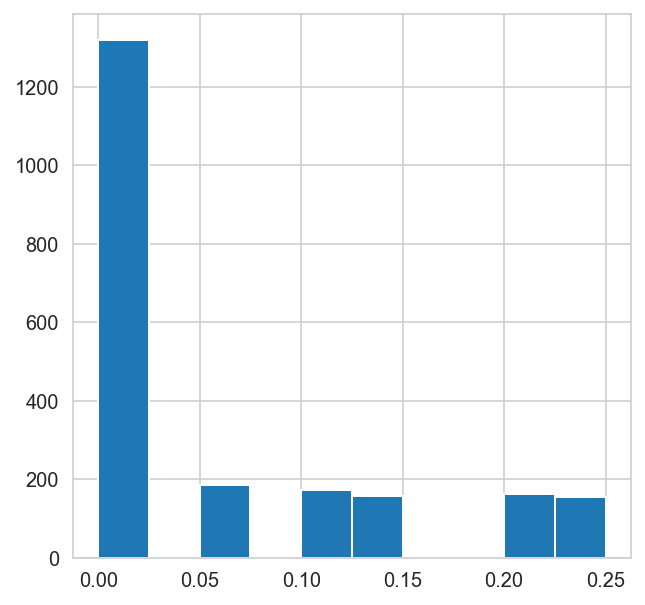

In [5]:
ord_det.Discount.hist(figsize = (5,5));

Since there are not that many levels of discount, I also inspect the count of each discount as a table.

In [6]:
ord_det['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Confirming the histogram that more than half have no discount, and discounts are evenly split at 5, 10, 15, 20, 25. 
There are some small discount levels with very quantities that don't show up on the histogram

Further investigating the smallest distribution of discounts
Filter on the discount level: 1%, 2%, 3%, 4%, 6%

In [7]:
ord_det.loc[(ord_det['Discount'] <= 0.06) & (ord_det['Discount'] != 0.05) & (ord_det['Discount'] != 0.00)]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
2133,11077/6,11077,6,25.00,1,0.02,25.00,24.5000,0.5000,1
2139,11077/14,11077,14,23.25,1,0.03,23.25,22.5525,0.6975,1
2140,11077/16,11077,16,17.45,2,0.03,34.90,33.8530,1.0470,1
2141,11077/20,11077,20,81.00,1,0.04,81.00,77.7600,3.2400,1
2146,11077/46,11077,46,12.00,3,0.02,36.00,35.2800,0.7200,1
2149,11077/60,11077,60,34.00,2,0.06,68.00,63.9200,4.0800,1
2150,11077/64,11077,64,33.25,2,0.03,66.50,64.5050,1.9950,1
2152,11077/73,11077,73,15.00,2,0.01,30.00,29.7000,0.3000,1


That's strange they all have the same order number. Let's look at the total order to see if that gives us any clues

In [8]:
ord_11077 = ord_det[(ord_det['OrderId'] == 11077)]
ord_11077.sort_values(by=['Discount', 'Quantity'], ascending=False)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
2130,11077/2,11077,2,19.00,24,0.20,456.00,364.8000,91.2000,1
2135,11077/8,11077,8,40.00,2,0.10,80.00,72.0000,8.0000,1
2149,11077/60,11077,60,34.00,2,0.06,68.00,63.9200,4.0800,1
2137,11077/12,11077,12,38.00,2,0.05,76.00,72.2000,3.8000,1
2144,11077/39,11077,39,18.00,2,0.05,36.00,34.2000,1.8000,1
2134,11077/7,11077,7,30.00,1,0.05,30.00,28.5000,1.5000,1
2141,11077/20,11077,20,81.00,1,0.04,81.00,77.7600,3.2400,1
2140,11077/16,11077,16,17.45,2,0.03,34.90,33.8530,1.0470,1
2150,11077/64,11077,64,33.25,2,0.03,66.50,64.5050,1.9950,1
2139,11077/14,11077,14,23.25,1,0.03,23.25,22.5525,0.6975,1


Nothing in this order jumps out as unusual, how about by product and Category?

In [9]:
cur.execute("""SELECT OrderId, ProductId, od.UnitPrice, Quantity, Discount,
                ProductName, CategoryId,
                CategoryName
                FROM [OrderDetail] od
                JOIN [Product] p
                ON od.ProductId = p.Id
                JOIN Category c
                ON c.Id = p.CategoryId
                WHERE OrderId == '11077' 
                AND Discount >= '0.01' AND Discount <= '0.06' AND Discount != '0.05' """);
                      
what_prod_df = pd.DataFrame(cur.fetchall())
what_prod_df.columns = [i[0] for i in cur.description]
what_prod_df.sort_values(by=['CategoryName'])

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryId,CategoryName
0,11077,6,25.00,1,0.02,Grandma's Boysenberry Spread,2,Condiments
2,11077,16,17.45,2,0.03,Pavlova,3,Confections
3,11077,20,81.00,1,0.04,Sir Rodney's Marmalade,3,Confections
5,11077,60,34.00,2,0.06,Camembert Pierrot,4,Dairy Products
6,11077,64,33.25,2,0.03,Wimmers gute Semmelknödel,5,Grains/Cereals
1,11077,14,23.25,1,0.03,Tofu,7,Produce
4,11077,46,12.00,3,0.02,Spegesild,8,Seafood
7,11077,73,15.00,2,0.01,Röd Kaviar,8,Seafood


The order covers multiple catageories and has different discounts within each. 
Let's see who placed the order, and we'll follow up with a question to them.

In [10]:
cur.execute("""SELECT DISTINCT OrderId,
                FirstName, LastName, Title, City, Country
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Employee e
                ON o.EmployeeId = e.Id
                WHERE OrderId == '11077' """);
                      
Who_df = pd.DataFrame(cur.fetchall())
Who_df.columns = [i[0] for i in cur.description]
Who_df

,OrderId,FirstName,LastName,Title,City,Country
0,11077,Nancy,Davolio,Sales Representative,Seattle,USA


Although this is outside of my research. I do have a follow up question for Nancy Davolio. **Why does this order have unusual discounts?**

As there are not a lot of these 'rogue' discounts. I'm going to include them with the lowest discount level of 5%. 
Query the database and create a new column that groups the discounts in 5% increments. (Only changing 1,2,3,4,6%)

In [11]:
cur.execute("""SELECT *,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1',
                    CASE
                    WHEN od.Discount BETWEEN 0.01 AND 0.06 THEN 0.05
                    ELSE od.Discount
                    END AS 'Disc_Group'
                FROM [OrderDetail] od;""")
ord_det = pd.DataFrame(cur.fetchall())
ord_det.columns = [i[0] for i in cur.description]
ord_det.head(8)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1,Disc_Group
0,10248/11,10248,11,14.0,12,0.00,168.0,168.0,0.0,0,0.00
1,10248/42,10248,42,9.8,10,0.00,98.0,98.0,0.0,0,0.00
2,10248/72,10248,72,34.8,5,0.00,174.0,174.0,0.0,0,0.00
3,10249/14,10249,14,18.6,9,0.00,167.4,167.4,0.0,0,0.00
4,10249/51,10249,51,42.4,40,0.00,1696.0,1696.0,0.0,0,0.00
5,10250/41,10250,41,7.7,10,0.00,77.0,77.0,0.0,0,0.00
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.4,222.6,1,0.15
7,10250/65,10250,65,16.8,15,0.15,252.0,214.2,37.8,1,0.15


## Pre-test

Separate the data into discounted and non discounted. This makes it easier to perform some tests.

In [12]:
disc = ord_det[ord_det['Discount']>0]
no_disc = ord_det[ord_det['Discount']==0]

In [13]:
disc.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1,Disc_Group
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.40,222.60,1,0.15
7,10250/65,10250,65,16.8,15,0.15,252.0,214.20,37.80,1,0.15
8,10251/22,10251,22,16.8,6,0.05,100.8,95.76,5.04,1,0.05
9,10251/57,10251,57,15.6,15,0.05,234.0,222.30,11.70,1,0.05
11,10252/20,10252,20,64.8,40,0.05,2592.0,2462.40,129.60,1,0.05


In [14]:
len(ord_det), len(no_disc), len(disc)

(2155, 1317, 838)

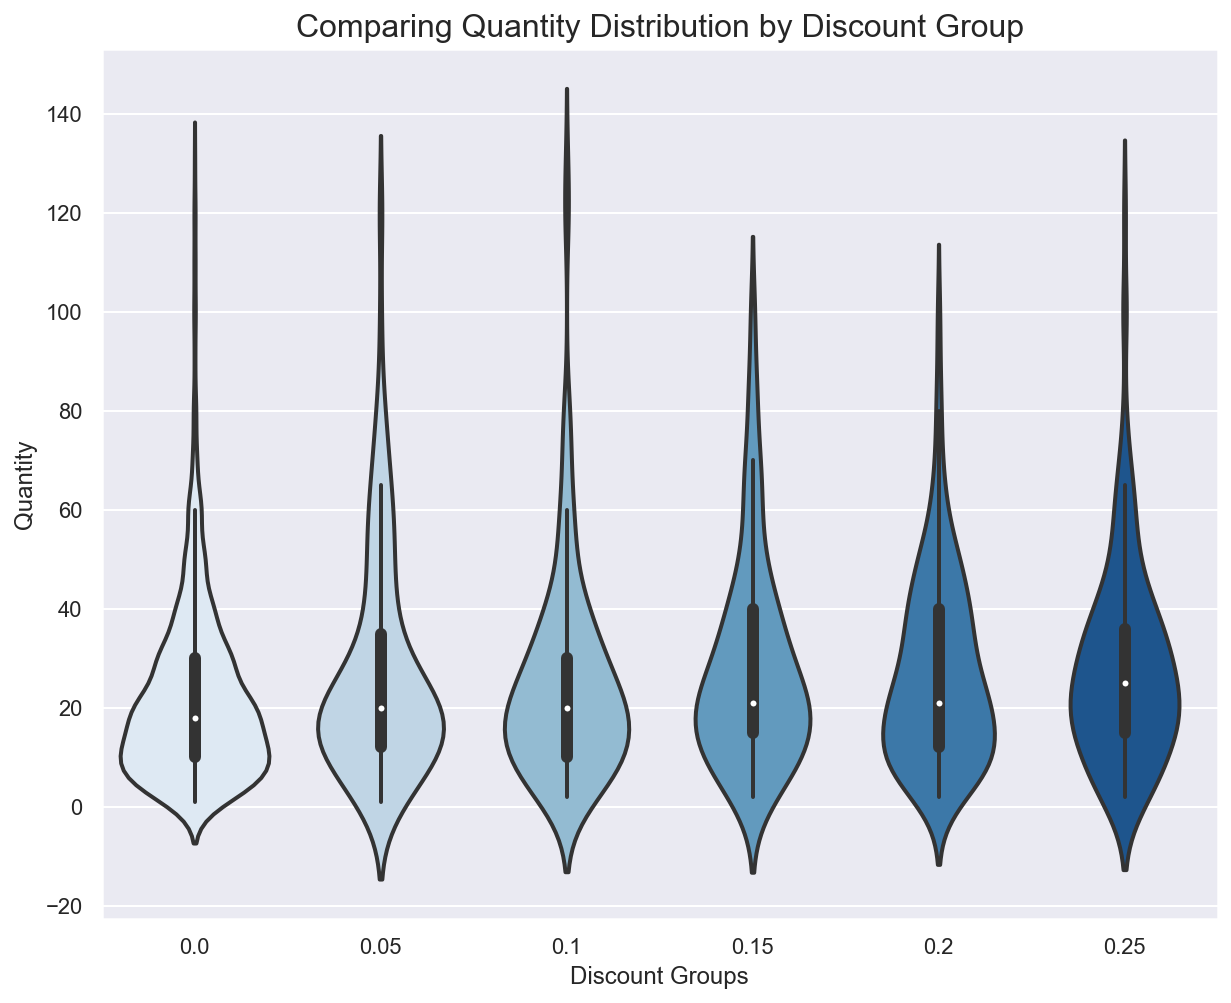

In [15]:
# Violin plot by discount group
sns.set(rc={'figure.figsize':(10,8)})
sns.set(color_codes=True)
sns.violinplot( x=ord_det["Disc_Group"], y=ord_det["Quantity"], linewidth=2, palette="Blues")
plt.xlabel("Discount Groups")
plt.ylabel("Quantity")
plt.title('Comparing Quantity Distribution by Discount Group', fontsize = 16)
plt.show();

**Interpretation**
All the discount groups have a higher mean and interquartile range than the non-discount group. The discount groups have a flatter, more spread distribution than non-discount; especially at 20% and 25% discount. The 10% has a similar mean to 5% and 15%, but the interquartile range appears to be lower and of a smaller range.

Test to see if the distributions are normal

In [16]:
stat.normaltest(disc['Quantity'])

NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)

In [17]:
stat.normaltest(no_disc['Quantity'])

NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)

The normal test has a null hypothesis that the distribution is normal. However, in our case the p-values are tiny, so we reject the null hypothesis. The most common alpha value is $\alpha = 0.05$. Even with a value much smaller than this we would reject the null hypothesis.

$p < \alpha$: Reject the Null Hypothesis that the distribution is normal.

Let's inspect the two distributions visually

In [18]:
# naming the discount / non discount series for simplicty
Discount_Qty = disc['Quantity']
No_Discount_Qty = no_disc['Quantity']

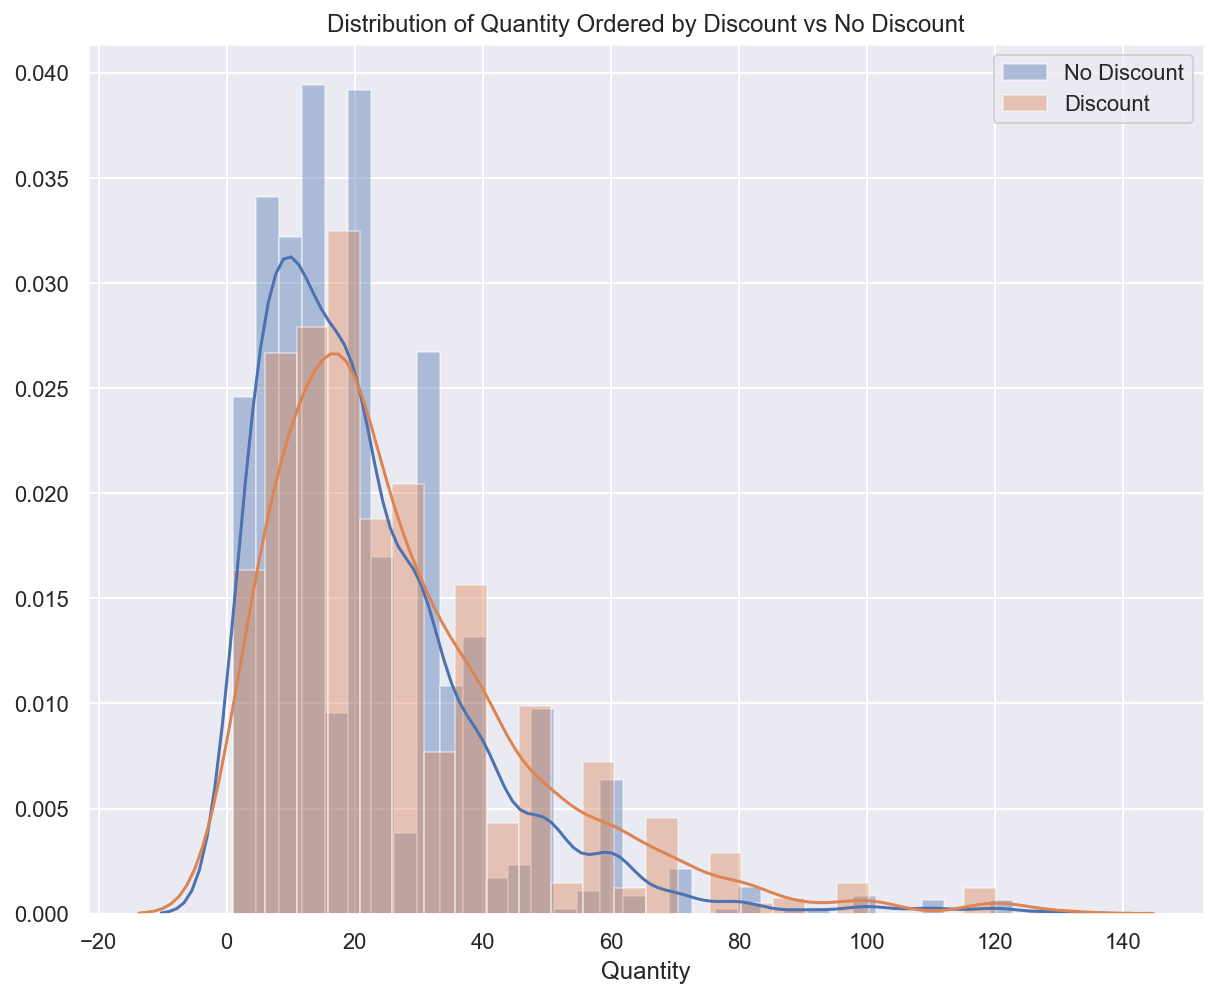

In [19]:
# Plot with overlapping of distribution means and sds

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(No_Discount_Qty, label='No Discount') # blue dist
sns.distplot(Discount_Qty, label='Discount') # orange dist
plt.title('Distribution of Quantity Ordered by Discount vs No Discount')
plt.legend()
plt.show();

We see a similar distribution shape between discount and no discount. The discount appears to have a higher mean, in that its peak is at a higher quantity.

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that discounts have no effect on sales order quantity.

We will perform four test in the experiment section. We are performing a one-tail test - as we are interested in whether discounts **increase** order quantity, rather than whether they change (increase or decrease) order quantity.

### 1. Welch's t-test
Used to compare the means of two groups of samples when the variances are different.

### 2. Cohen's d
Used to measure the effect size, or the strength of the relationship between the two samples. It measured the standardize difference between two means.

### 3. ANOVA
ANOVA (Analysis of Variance) is a method for generalizing statistical tests to multiple groups. ANOVA analyses the overall variance of a dataset. It is useful for testing more than two means - all discount groups in our example.

### 4. Tukey Test
Is used after an ANOVA test. While an ANOVA test can tell you whether your results are significant overall, it won’t tell significance within groups. This test compares all possible pairs of means.

### Welch's t-test

In [20]:
Welch_ttest = stat.ttest_ind(No_Discount_Qty, Discount_Qty, equal_var=False)
print(Welch_ttest)
print("This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. \np-value is:", 
      round(Welch_ttest[1]/2,14))

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)
This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. 
p-value is: 2.8282e-10


#### Interpretation
We get a p-value of 2.8282e-10, this is less than our $\alpha = 0.05$

Since $p < \alpha$ we reject the Null Hypothesis that discount has no effect on order quantity. There is statistical evidence at the 5% level of significance that the mean order quantity of discounted orders is greater than the mean order quantity with no discount.


### Cohen's d

In [21]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [22]:
Cohen_d(Discount_Qty, No_Discount_Qty)

0.2862724481729283

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that discounts have a **small** statistically significant effect on order quantity

### ANOVA

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [28]:
f1 = 'Disc_Group'
f2 = 'Quantity'

In [29]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, ord_det).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F        PR(>F)
C(Disc_Group)   15969.214452     5.0  8.990431  1.816734e-08
Residual       763430.421743  2149.0       NaN           NaN


#### Interpretation
With ANOVA we are testing whether there is a significant difference between discount groups.
The model gives us a p-value of 1.8167e-08, which is less than our $\alpha = 0.05$. We can reject the Null Hypothesis that there is no difference between groups. We don't know which specific levels of discount are significant, only that in total they are significant.

### Tukey test

In [30]:
mc = MultiComparison(ord_det.Quantity, ord_det.Disc_Group)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   5.207    1.0635  9.3506  True 
 0.0    0.1    3.5217  -0.8257  7.8692 False 
 0.0    0.15   6.6669   2.1279 11.2059  True 
 0.0    0.2    5.3096   0.8212  9.7979  True 
 0.0    0.25   6.525    1.9467 11.1033  True 
 0.05   0.1   -1.6853  -7.3138  3.9432 False 
 0.05   0.15   1.4599  -4.3179  7.2377 False 
 0.05   0.2    0.1026  -5.6355  5.8406 False 
 0.05   0.25   1.318   -4.4907  7.1267 False 
 0.1    0.15   3.1452  -2.7805  9.0709 False 
 0.1    0.2    1.7879  -4.0991  7.6748 False 
 0.1    0.25   3.0033  -2.9526  8.9591 False 
 0.15   0.2   -1.3573  -7.3872  4.6725 False 
 0.15   0.25  -0.1419   -6.239  5.9552 False 
 0.2    0.25   1.2154  -4.8441  7.2749 False 
---------------------------------------------
[0.   0.05 0.1  0.15 0.2  0.25]


#### Interpretation
Discount levels of 5%, 15%, 20% and 25% produce a significant difference compared against no discount. However, there is no significant difference between the different levels of discount.

## Conclusion

* There is sufficent evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

# Hypothesis #2: Categories

## $H_{0}$ Null Hypothesis
**There is no difference in sales order quantity between product categories.**

## $H_{1}$ Alternative Hypothesis
**There is a difference in sales order quantity between product categories**

Getting data for Categories.
Test - there is no difference in discount level by Category

In [4]:
cur.execute("""SELECT OrderId, ProductId, od.UnitPrice, Quantity, Discount,
                ProductName, CategoryId, CategoryName, ShippedDate,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                JOIN [Product] p
                ON od.ProductId = p.Id
                JOIN Category c
                ON c.Id = p.CategoryId""");
                      
Cat_df = pd.DataFrame(cur.fetchall())
Cat_df.columns = [i[0] for i in cur.description]
print(len(Cat_df))
Cat_df.head()

OperationalError: no such column: ShippedDate

Group by Category Name to inspect aggregations

In [32]:
cat_summary = Cat_df.groupby(Cat_df.CategoryName).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean'})
cat_summary

Quantity                      GrossRev  UnitPrice
                  count   sum       mean          sum       mean
CategoryName                                                    
Beverages           404  9532  23.594059  267868.1800  29.236757
Condiments          216  5298  24.527778  106047.0850  21.320833
Confections         334  7906  23.670659  167357.2250  22.602695
Dairy Products      366  9149  24.997268  234507.2850  26.983060
Grains/Cereals      196  4562  23.275510   95744.5875  21.246429
Meat/Poultry        173  4199  24.271676  163022.3595  42.874740
Produce             136  2990  21.985294   99984.5800  35.194485
Seafood             330  7681  23.275758  131261.7375  19.062970

View Category by Total Order Quantity

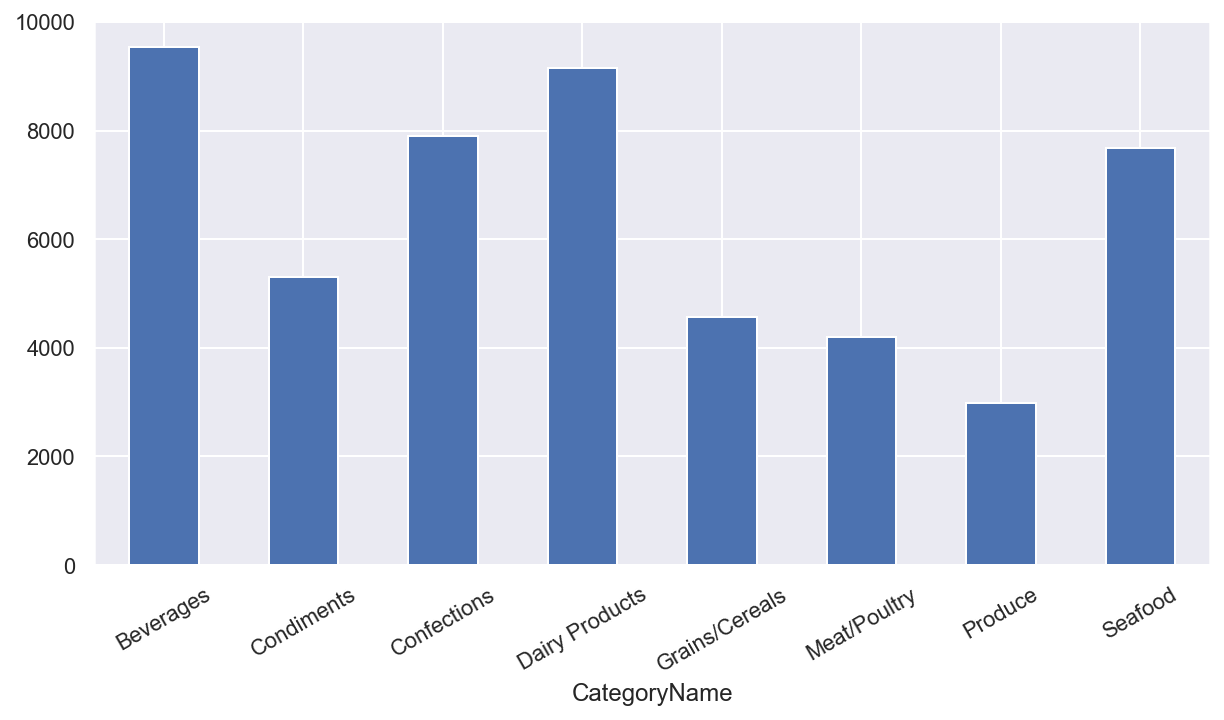

In [33]:
plt.figure(figsize=(10,5))
sum = Cat_df.groupby('CategoryName')['Quantity'].sum()
sum.plot.bar(x='CategoryName', y='Quantity')
plt.xticks(rotation=30)
plt.show();

View Category by Total Gross Revenue

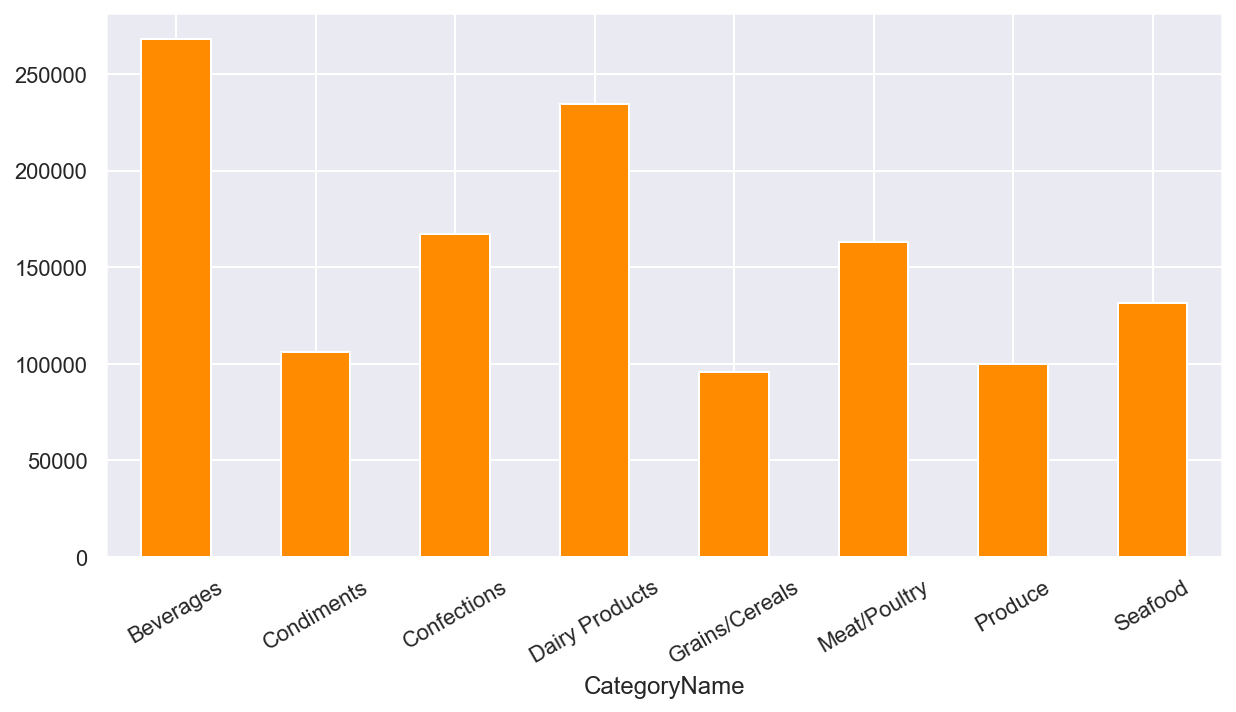

In [34]:
plt.figure(figsize=(10,5))
sum = Cat_df.groupby('CategoryName')['GrossRev'].sum()
sum.plot.bar(x='CategoryName', y='GrossRev', color='darkorange')
plt.xticks(rotation=30)
plt.show();

Category by mean order quantity

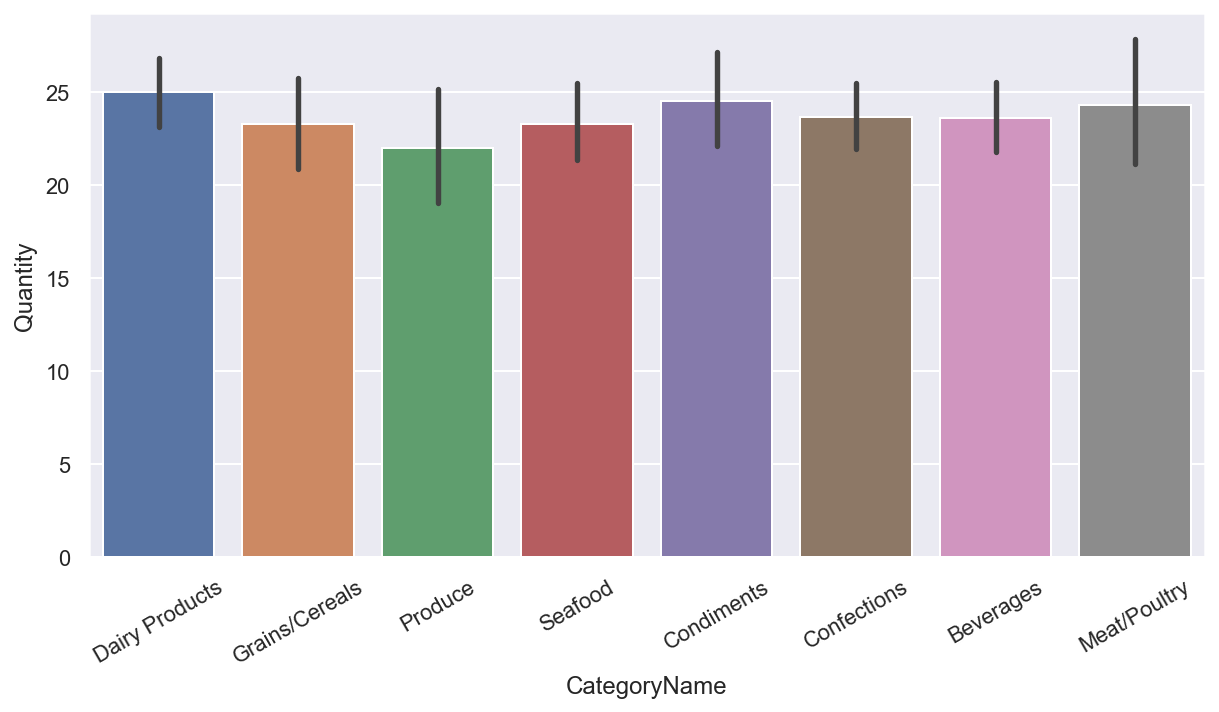

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x='CategoryName', y='Quantity', data=Cat_df)
plt.xticks(rotation=30)
plt.show();

Category by mean order revenue

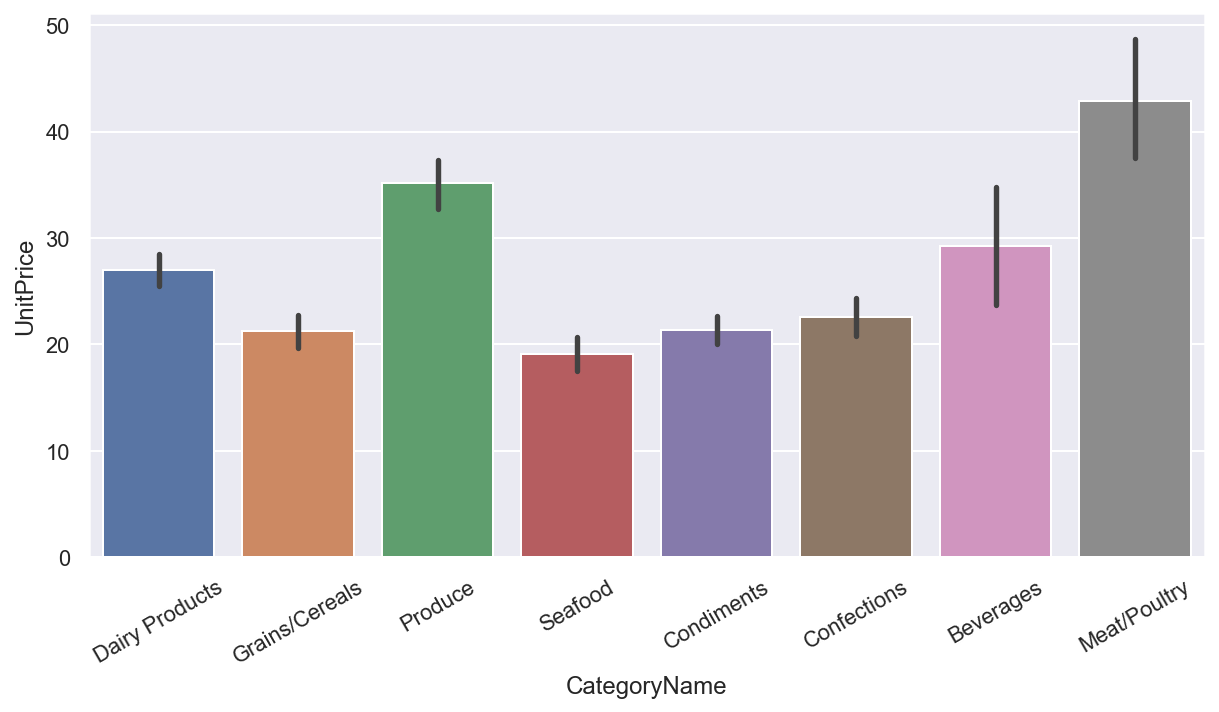

In [36]:
plt.figure(figsize=(10,5))
sns.barplot(x='CategoryName', y='UnitPrice', data=Cat_df)
plt.xticks(rotation=30)
plt.show();

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that product Categories have no effect on sales order quantity.

For this experiment we are testing multiple groups. So we will only perform ANOVA and Tukey Test.

### ANOVA

In [37]:
f1 = 'CategoryName'
f2 = 'Quantity'

In [38]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, Cat_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq      df         F    PR(>F)
C(CategoryName)    1292.377084     7.0  0.509429  0.828058
Residual         778107.259110  2147.0       NaN       NaN


#### Interpretation
The model gives us a p-value of 0.8281, which is greater than our $\alpha = 0.05$. There is insufficient evidence to reject the Null Hypothesis that there is no difference between groups.

### Tukey test

In [41]:
mc = MultiComparison(Cat_df.Quantity, Cat_df.CategoryName)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower  upper  reject
------------------------------------------------------------
  Beverages      Condiments    0.9337  -3.9346 5.802  False 
  Beverages     Confections    0.0766  -4.1947 4.3479 False 
  Beverages    Dairy Products  1.4032  -2.7647 5.5711 False 
  Beverages    Grains/Cereals -0.3185  -5.3461 4.709  False 
  Beverages     Meat/Poultry   0.6776  -4.5701 5.9254 False 
  Beverages       Produce     -1.6088  -7.3346 4.117  False 
  Beverages       Seafood     -0.3183  -4.6038 3.9672 False 
  Condiments    Confections   -0.8571    -5.9  4.1858 False 
  Condiments   Dairy Products  0.4695  -4.4861 5.4251 False 
  Condiments   Grains/Cereals -1.2523  -6.9499 4.4454 False 
  Condiments    Meat/Poultry  -0.2561  -6.1489 5.6367 False 
  Condiments      Produce     -2.5425  -8.8648 3.7798 False 
  Condiments      Seafood      -1.252  -6.3069 3.8029 False 
 Confections   Dairy Pro

#### Interpretation
Discount levels of 5%, 15%, 20% and 25% produce a significant difference compared against no discount. However, there is no significant difference between the different levels of discount.

## Conclusion

* There is sufficent evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

## Future Work appendix

In [ ]:
Cat_df.groupby('CategoryName')['Quantity', 'UnitPrice'].describe()

Comparing distribution of Beverages (high total quantity and revenue) vs Produce (low total quantity and revenue)

In [ ]:
Bev_df = Cat_df[Cat_df['CategoryName'] == 'Beverages']
Prod_df = Cat_df[Cat_df['CategoryName'] == 'Produce']

In [ ]:
Bev_df.Quantity.hist(figsize = (5,5)), Prod_df.Quantity.hist(figsize = (5,5));


In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.lmplot( x="UnitPrice", y="Quantity", data=Cat_df, fit_reg=False, hue='CategoryName', legend=True, aspect= 2, markers =".")
# plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.show();

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.lmplot( x="UnitPrice", y="Quantity", data=Cat_df, fit_reg=False, hue='CategoryName', legend=True, aspect= 2, markers =".")
ax.set(xlim=(0,50))
# plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.show();


In [ ]:
Cat_df.loc[Cat_df['UnitPrice'] > 100]

In [ ]:
Cat_df['UnitPrice'].describe()

# Hypothesis #3: Employees

## $H_{0}$ Null Hypothesis
**Discounts have no effect on sales order quantity.**

## $H_{1}$ Alternative Hypothesis
**Discounts lead to an increase in sales order quantity**

In [ ]:
# Getting data for Employees
# There is no discount in revenue by employee
# Discounted vs non-discounted
# Average discount - might need a group by??

In [15]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount, OrderDate, ShippedDate, RequiredDate,
                LastName, Title, City, Country, e.Id,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                JOIN [Order] o
                ON od.OrderId = o.Id
                JOIN Employee e
                ON e.Id = o.EmployeeId""");
                      
Emp_df = pd.DataFrame(cur.fetchall())
Emp_df.columns = [i[0] for i in cur.description]
print(len(Emp_df))
Emp_df.head(10)

2155


,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,RequiredDate,LastName,Title,City,Country,Id,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248,11,14.0,12,0.00,2012-07-04,2012-07-16,2012-08-01,Buchanan,Sales Manager,London,UK,5,168.0,168.00,0.00,0
1,10248,42,9.8,10,0.00,2012-07-04,2012-07-16,2012-08-01,Buchanan,Sales Manager,London,UK,5,98.0,98.00,0.00,0
2,10248,72,34.8,5,0.00,2012-07-04,2012-07-16,2012-08-01,Buchanan,Sales Manager,London,UK,5,174.0,174.00,0.00,0
3,10249,14,18.6,9,0.00,2012-07-05,2012-07-10,2012-08-16,Suyama,Sales Representative,London,UK,6,167.4,167.40,0.00,0
4,10249,51,42.4,40,0.00,2012-07-05,2012-07-10,2012-08-16,Suyama,Sales Representative,London,UK,6,1696.0,1696.00,0.00,0
5,10250,41,7.7,10,0.00,2012-07-08,2012-07-12,2012-08-05,Peacock,Sales Representative,Redmond,USA,4,77.0,77.00,0.00,0
6,10250,51,42.4,35,0.15,2012-07-08,2012-07-12,2012-08-05,Peacock,Sales Representative,Redmond,USA,4,1484.0,1261.40,222.60,1
7,10250,65,16.8,15,0.15,2012-07-08,2012-07-12,2012-08-05,Peacock,Sales Representative,Redmond,USA,4,252.0,214.20,37.80,1
8,10251,22,16.8,6,0.05,2012-07-08,2012-07-15,2012-08-05,Leverling,Sales Representative,Kirkland,USA,3,100.8,95.76,5.04,1
9,10251,57,15.6,15,0.05,2012-07-08,2012-07-15,2012-08-05,Leverling,Sales Representative,Kirkland,USA,3,234.0,222.30,11.70,1


In [ ]:
emp = Emp_df.groupby(Emp_df.LastName).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean', 'DiscVal': 'sum'})
emp

In [ ]:
cur.execute("""SELECT DISTINCT
                Id, FirstName, LastName, Title, City, Country
                FROM Employee e
                """);
                      
Emp_list = pd.DataFrame(cur.fetchall())
Emp_list.columns = [i[0] for i in cur.description]
Emp_list

In [ ]:
drop fuller, buchanan, callahan

In [ ]:
Emp_df2 = Emp_df.drop(Emp_df[(Emp_df['Id'] == 2) | (Emp_df['Id'] == 5) | (Emp_df['Id'] == 8)].index).sort_values('Country')
Emp_df2.shape

In [ ]:
# stacked bar - rev by employ, disc and non-disc

plt.figure(figsize=(10,5))
sum = Emp_df2.groupby('LastName')['GrossRev'].sum()
sum.plot.bar(x='LastName', y='GrossRev', color='darkorange')
plt.xticks(rotation=30)
plt.show();

In [ ]:
area - total rev by employee

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='Quantity', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='GrossRev', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='DiscVal', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that discounts have no effect on sales order quantity.

We will perform four test in the experiment section. We are performing a one-tail test - as we are interested in whether discounts **increase** order quantity, rather than whether they change (increase or decrease) order quantity.

### 1. Welch's t-test
Used to compare the means of two groups of samples when the variances are different.

### 2. Cohen's d
Used to measure the effect size, or the strength of the relationship between the two samples. It measured the standardize difference between two means.

### 3. ANOVA
ANOVA (Analysis of Variance) is a method for generalizing statistical tests to multiple groups. ANOVA analyses the overall variance of a dataset. It is useful for testing more than two means - all discount groups in our example.

### 4. Tukey Test
Is used after an ANOVA test. While an ANOVA test can tell you whether your results are significant overall, it won’t tell significance within groups. This test compares all possible pairs of means.

### Welch's t-test

In [ ]:
Welch_ttest = stat.ttest_ind(No_Discount_Qty, Discount_Qty, equal_var=False)
print(Welch_ttest)
print("This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. \np-value is:", 
      round(Welch_ttest[1]/2,14))

#### Interpretation
We get a p-value of 2.8282e-10, this is less than our $\alpha = 0.05$

Since $p < \alpha$ we reject the Null Hypothesis that discount has no effect on order quantity. There is statistical evidence at the 5% level of significance that the mean order quantity of discounted orders is greater than the mean order quantity with no discount.


### Cohen's d

In [ ]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
Cohen_d(Discount_Qty, No_Discount_Qty)

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that discounts have a **small** statistically significant effect on order quantity

### ANOVA

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
f1 = 'Disc_Group'
f2 = 'Quantity'

In [ ]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, ord_det).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

#### Interpretation
With ANOVA we are testing whether there is a significant difference between discount groups.
The model gives us a p-value of 1.8167e-08, which is less than our $\alpha = 0.05$. We can reject the Null Hypothesis that there is no difference between groups. We don't know which specific levels of discount are significant, only that in total they are significant.

### Tukey test

In [ ]:
mc = MultiComparison(ord_det.Quantity, ord_det.Disc_Group)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

#### Interpretation
Discount levels of 5%, 15%, 20% and 25% produce a significant difference compared against no discount. However, there is no significant difference between the different levels of discount.

## Conclusion

* There is sufficent evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

## Tests

# Hypothesis #4: Regions

## $H_{0}$ Null Hypothesis
**Discounts have no effect on sales order quantity.**

## $H_{1}$ Alternative Hypothesis
**Discounts lead to an increase in sales order quantity**

In [ ]:
# Getting data for region
# There is no difference in revenue by region

In [ ]:
# reload table from source

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
Cust_Reg_df.isna().sum()

In [ ]:
cur.execute("""SELECT DISTINCT CustomerId, c.Id AS Cust_Table_Id, City, Country
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId
                WHERE City IS NULL""");
                      
Miss_Reg_df = pd.DataFrame(cur.fetchall())
Miss_Reg_df.columns = [i[0] for i in cur.description]
print(len(Miss_Reg_df))
Miss_Reg_df.head(10)

In [ ]:
cur.execute("""SELECT Id, CompanyName
                FROM [Customer] 
                WHERE Id LIKE 'DUMO%' 
                OR Id LIKE 'ANTO%'
                OR Id LIKE 'QUEE%' 
                OR Id LIKE 'OCEA%' """);
df = pd.DataFrame(cur.fetchall())
df

In [ ]:
# This works for select, but doesn't update

# cur.execute("""SELECT CustomerId,
#                 REPLACE (
#                 REPLACE (
#                 REPLACE (
#                 REPLACE (CustomerId, 'DUMO', 'DUMON'), 
#                 'ANTO', 'ANTON'),
#                 'QUEE', 'QUEEN'),
#                 'OCEA', 'OCEAN')
#                 FROM [Order] """);

In [ ]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'DUMON'
                WHERE CustomerId = 'DUMO'
                """);

In [ ]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'ANTON'
                WHERE CustomerId = 'ANTO'
                """);

In [ ]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'QUEEN'
                WHERE CustomerId = 'QUEE'
                """);

In [ ]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'OCEAN'
                WHERE CustomerId = 'OCEA'
                """);

In [ ]:
cur.execute("""SELECT COUNT(CompanyName), Country, Region 
                FROM [Customer] 
                GROUP BY Country 
                ORDER By Region""");
df = pd.DataFrame(cur.fetchall())
df

In [ ]:
cur.execute("""SELECT Region, COUNT(CompanyName) AS 'Num_Cust'
                FROM [Customer] 
                GROUP BY Region 
                ORDER By Region""");
count_df = pd.DataFrame(cur.fetchall())
count_df.columns = [i[0] for i in cur.description]
count_df

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(count_df.Region, count_df.Num_Cust)
plt.xticks(rotation=30)
plt.show();

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head()

In [ ]:
Cust_Reg_df['Continent'] = np.where(Cust_Reg_df['Region'].str.contains('America'), 'America', 'Europe')

In [ ]:
Cust_Reg_df = Cust_Reg_df.sort_values(['Continent','Region', 'Country'])


In [ ]:
cntry_sum = Cust_Reg_df.groupby(['Country']).sum()
cntry_sum

In [ ]:
lat = [-38.4161, 
47.5162, 
50.5039, 
-14.235, 
56.1304, 
56.2639, 
61.9241, 
46.2276, 
51.1657, 
53.1424, 
41.8719, 
23.6345, 
60.472, 
51.9194, 
39.3999, 
40.4637, 
60.1282, 
46.8182, 
55.3781, 
37.0902, 
6.4238 
]

In [ ]:
cntry_sum['Latitude'] = lat

In [ ]:
long = [-63.6167, 
14.5501, 
4.4699, 
-51.9253, 
-106.3468, 
9.5018, 
25.7482, 
2.2137, 
10.4515, 
-7.6921, 
12.5674, 
-102.5528, 
8.4689, 
19.1451, 
-8.2245, 
-3.7492, 
18.6435, 
8.2275, 
-3.436, 
-95.7129, 
-66.5897 ]


In [ ]:
cntry_sum['Longitude'] = long

In [ ]:
cntry_sum

In [ ]:
# Make a data frame with dots to show on the map
data = cntry_sum
 
# Make an empty map
m = folium.Map(location=[30, -30], zoom_start=3)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.CircleMarker([data.iloc[i]['Latitude'], data.iloc[i]['Longitude']],
                radius=data.iloc[i]['GrossRev']/10000,
                color='darkorange',
                fill=True,
                fill_color='darkorange'
                ).add_to(m)

m.save('mymap.html')
m

In [ ]:
cntry = Cust_Reg_df.groupby(['Continent','Region', 'Country']).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean', 'DiscVal': 'sum'})
cntry

In [ ]:
df1=Cust_Reg_df.groupby(['Region'])['GrossRev','DiscVal'].sum()
df1.plot(kind='bar',stacked=True,legend=True);


In [ ]:
df2=Cust_Reg_df.groupby(['Region'])['GrossRev','DiscVal'].mean()
df2.plot(kind='bar',stacked=True,legend=True);


In [ ]:
reg = Cust_Reg_df.groupby(['Continent']).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': ['count', 'sum', 'mean'], 'UnitPrice': 'mean', 'DiscVal': 'sum'})
reg

In [ ]:
# ave order quantity by region

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that discounts have no effect on sales order quantity.

We will perform four test in the experiment section. We are performing a one-tail test - as we are interested in whether discounts **increase** order quantity, rather than whether they change (increase or decrease) order quantity.

### 1. Welch's t-test
Used to compare the means of two groups of samples when the variances are different.

### 2. Cohen's d
Used to measure the effect size, or the strength of the relationship between the two samples. It measured the standardize difference between two means.

### 3. ANOVA
ANOVA (Analysis of Variance) is a method for generalizing statistical tests to multiple groups. ANOVA analyses the overall variance of a dataset. It is useful for testing more than two means - all discount groups in our example.

### 4. Tukey Test
Is used after an ANOVA test. While an ANOVA test can tell you whether your results are significant overall, it won’t tell significance within groups. This test compares all possible pairs of means.

### Welch's t-test

In [ ]:
Welch_ttest = stat.ttest_ind(No_Discount_Qty, Discount_Qty, equal_var=False)
print(Welch_ttest)
print("This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. \np-value is:", 
      round(Welch_ttest[1]/2,14))

#### Interpretation
We get a p-value of 2.8282e-10, this is less than our $\alpha = 0.05$

Since $p < \alpha$ we reject the Null Hypothesis that discount has no effect on order quantity. There is statistical evidence at the 5% level of significance that the mean order quantity of discounted orders is greater than the mean order quantity with no discount.


### Cohen's d

In [ ]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
Cohen_d(Discount_Qty, No_Discount_Qty)

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that discounts have a **small** statistically significant effect on order quantity

### ANOVA

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
f1 = 'Disc_Group'
f2 = 'Quantity'

In [ ]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, ord_det).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

#### Interpretation
With ANOVA we are testing whether there is a significant difference between discount groups.
The model gives us a p-value of 1.8167e-08, which is less than our $\alpha = 0.05$. We can reject the Null Hypothesis that there is no difference between groups. We don't know which specific levels of discount are significant, only that in total they are significant.

### Tukey test

In [ ]:
mc = MultiComparison(ord_det.Quantity, ord_det.Disc_Group)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

#### Interpretation
Discount levels of 5%, 15%, 20% and 25% produce a significant difference compared against no discount. However, there is no significant difference between the different levels of discount.

## Conclusion

* There is sufficent evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

# Extra - delete from project

In [ ]:
# how to do in pandas - no longer necessary

In [ ]:
ord_det['ListRev'] = ord_det['UnitPrice'] * ord_det['Quantity']

In [ ]:
ord_det['GrossRev'] = ord_det['UnitPrice'] * ord_det['Quantity'] * (1 - (ord_det['Discount']))

In [ ]:
ord_det['Disc_Val'] = ord_det['ListRev'] - ord_det['GrossRev']

In [ ]:
ord_det['Disc_0_1'] = np.where(ord_det['Discount'] == 0, 0, 1)

In [ ]:
ord_det.head(12)

In [ ]:
# check column names - for personal exploration

In [5]:
db_filename = 'Northwind_small.sqlite'
newline_indent = '\n   '

db=sqlite3.connect(db_filename)
db.text_factory = str
cur = db.cursor()

result = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
table_names = sorted(list(zip(*result))[0])
print ("\ntables are:"+newline_indent+newline_indent.join(table_names))

for table_name in table_names:
    result = cur.execute("PRAGMA table_info('%s')" % table_name).fetchall()
    column_names = list(zip(*result))[1]
    print (("\ncolumn names for %s:" % table_name)
           +newline_indent
           +(newline_indent.join(column_names)))

db.close()
print ("\nexiting.")


tables are:
   Category
   Customer
   CustomerCustomerDemo
   CustomerDemographic
   Employee
   EmployeeTerritory
   Order
   OrderDetail
   Product
   Region
   Shipper
   Supplier
   Territory

column names for Category:
   Id
   CategoryName
   Description

column names for Customer:
   Id
   CompanyName
   ContactName
   ContactTitle
   Address
   City
   Region
   PostalCode
   Country
   Phone
   Fax

column names for CustomerCustomerDemo:
   Id
   CustomerTypeId

column names for CustomerDemographic:
   Id
   CustomerDesc

column names for Employee:
   Id
   LastName
   FirstName
   Title
   TitleOfCourtesy
   BirthDate
   HireDate
   Address
   City
   Region
   PostalCode
   Country
   HomePhone
   Extension
   Photo
   Notes
   ReportsTo
   PhotoPath

column names for EmployeeTerritory:
   Id
   EmployeeId
   TerritoryId

column names for Order:
   Id
   CustomerId
   EmployeeId
   OrderDate
   RequiredDate
   ShippedDate
   ShipVia
   Freight
   ShipName
   ShipAddress
  

In [ ]:
# Multiple ttests - for my benefit. This is bad practice

In [ ]:
for group in ord_det.groupby(['Disc_Group'])['Quantity']:
    group_name = group[0]
    print(group_name)

In [ ]:
from itertools import combinations

groups = [group[0] for group in ord_det.groupby(['Disc_Group'])['Quantity']]
combos = combinations(groups, 2)
for combo in combos:
    supp1 = combo[0]
    supp2 = combo[1]
    sample1 = ord_det[(ord_det.Disc_Group == supp1)]['Quantity']
    sample2 = ord_det[(ord_det.Disc_Group == supp2)]['Quantity']
    p = stats.ttest_ind(sample1, sample2, equal_var=False)
    print(combo, p)

In [ ]:
# Check loop result
disc_10 = ord_det[ord_det['Disc_Group']==0.10]
Discount_10_Qty = disc_10['Quantity']
stat.ttest_ind(No_Discount_Qty, Discount_10_Qty, equal_var=False)

In [ ]:
# Welch's t statistic - how to calculate manually

import numpy as np
import scipy.stats as stats

def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(a, b, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [ ]:
p_value_welch_ttest(Discount_Qty, No_Discount_Qty)

In [ ]:
# Cohen's d simplified formula ()
from statistics import mean, stdev
from math import sqrt

# test conditions
c0 = Discount_Qty
c1 = No_Discount_Qty

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

print(cohens_d)

In [16]:
# How to export as a csvcat_summary
Emp_df.to_csv (r'C:\Users\andrew\Documents\project2_df.csv', index = None, header=True)

In [ ]:
df3=Cust_Reg_df.groupby(['Disc_0_1'])['GrossRev'].sum()
df3

# Follow up question. How to filter get total for orders with at least one line discounted

In [ ]:
# SQL example
region_count = cur.execute("""SELECT COUNT(CompanyName), Region 
                FROM [Customer] 
                GROUP BY Region 
                ORDER By Region"""), cur.fetchall();
region_count

In [ ]:
for i, g in enumerate(Cust_Reg_df.groupby('Disc_0_1')):
    ax = sns.barplot(data=g[1],
                     x="Region",
                     y="GrossRev",
                     hue="Continent"
                     )
ax.legend_.remove() # remove the redundant legends 

In [ ]:
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador'],
'value':['10', '12', '15', '16', '8', '15', '21', '3']
})
data
 
# Make an empty map
m = folium.Map(location=[20, 0], zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.CircleMarker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name'],
                radius=data.iloc[i]['value'],
                color='crimson',
                fill=True,
                fill_color='crimson'
                ).add_to(m)

m.save('mymap.html')
m

In [ ]:
# Super test - employee by region ... doesn't work, many to many joins
# Delete this before draft to Victor

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                c.City, c.Country, c.Region r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Customer] c
                ON c.Id = o.CustomerId
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region
                FROM [OrderDetail] od
                LEFT JOIN [Order] ob
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
cur.execute("""SELECT * FROM [Employee] """);
                      
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
print(df.nunique())
df.head()

In [ ]:
cur.execute("""SELECT * FROM [Order] """);
                      
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
print(df.nunique())
df.head()

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                e.LastName, TerritoryId, TerritoryDescription,
                r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
# Notice that each line in the order is repeated multiple times. Employee has mulitple territories - 
#   we can't determine the unique territory based on employee id